In [66]:
# coding:utf-8
#!/usr/bin/python3
import os, cv2 #,matplotlib; matplotlib.use('Agg')
from pylab import * # import matplotlib & numpy
from tqdm import tqdm


# tp = [Type=0-3, Fix/Scale=0/1, Noise Scale=0-1]
#####################################################################
# Create Normalized Curve:
def Curve(tp, p, t): # normalized curve
    if type(tp)!=str: tp = "sps" # tp=tp[0]
    s1 = p[2] * np.sin((p[0]*t+p[1])*np.pi)
    s2 = p[5] * np.sin((p[3]*t+p[4])*np.pi)
    if "sps" in tp: return (s1 + s2)/(abs(p[2]) + abs(p[5]))
    if "sms" in tp: return (s1 * s2)/(abs(p[2]) * abs(p[5]))
    if len(p)>=9: s3 = p[8] * np.sin((p[6]*t+p[7])*np.pi)
    if "sss" in tp: return (s1 + s2 + s3)/(abs(p[2])+abs(p[5])+abs(p[8]))


# Get Random [linewidth, alpha] Pairs:
def LwAl(tp, n=1, dx=180): # random [linewidth, alpha] pair
    wa = np.random.rand(2*n); f = tp[1]*(dx/180-1)+1 # scale ratio
    wa[::2] = [round(f*(1.1*i+2),2) for i in wa[::2]] # linewidth
    wa[1::2] = [round(0.4*i+0.2,2) for i in wa[1::2]] # alpha
    if tp[0]==3: wa[::2] = round(f,2); # linewidth for tp=3
    return wa # type: np.array


# Rotate or Affine the Curve:
def RoAf(t, y, ra=0, af=None): # rotate or affine the curve
    if type(ra)!=np.ndarray: # rotational angle -> matrix
        
        ra *= np.pi; 
        ra = np.array([[cos(ra),-sin(ra)],[sin(ra),cos(ra)]])
    if type(af)==np.ndarray: ra = ra.dot(af); # affine & rotate
    y = ra.dot(np.array([t,y])) # rotate/affine the curve
    return y[0,:], y[1,:] # t'=y[0,:], y'=y[1,:]


# Draw Curve with Annotation:
def DrawCu(tp, p=None, xi=0, dx=20, yo=0, A=1, ra=0, af=0, wa=[]): # draw curve
    if type(tp)!=list and type(tp)!=tuple: tp = [tp,0,0] # default
    if p==None or len(p)<6: # default: random curve parameters
        p = [round(2*i,2) for i in np.random.rand(9)]; p[2]=p[5]=p[8]=1
    
    tp, fs, no = tp # tp[0]=Type, tp[1]=Fix/Scale, tp[2]=Noise Scale
    t = np.linspace(xi-dx, xi+dx, round(2*dx*(np.random.rand()+1)), endpoint=True)
    no = no/5 * (1+(tp==3)) * (np.random.rand(len(t))-0.5) # noise
    y = A * (Curve(tp,p,t) + yo + no) # vertically scale + translate
    t,y = RoAf(t-xi, y, ra, af) # horizontally adjust -> rotate/affine
    
    if len(wa)<2: wa = LwAl([tp,fs], 1, dx); # get [linewidth,alpha] pair
    an = str(tp)+": "+", ".join([str(i) for i in p])+"->"+", ".join([str(i) for i in wa])
    plot(t, y, color="k", lw=wa[0], alpha=wa[-1], label=an)
    return t, y, wa, p


#####################################################################
# Extract sps Cell Parameters:
def Paras(tp, dx, A, f): # Extract sps Cell Parameters
    tp, yf = tp[0], tp[1]*(dx/180-1)+1 # Cell scale ratio
    if tp==0: # Reticulate Pattern Type0
        A = 42*yf; f = 12/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
    elif tp==1: # Reticulate Pattern Type1
        A = 30*yf; f = 8/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.75]
    elif tp==2: # Reticulate Pattern Type2
        A = 55*yf; f = 8/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
        f = np.array([[1,-0.5],[-0.15,1]]); # Affine Matrix
    elif tp==3: # Reticulate Pattern Type3
        A = 10*yf; f = 7.5/dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8]
        f = np.array([[1.15,1.1],[-0.45,0.7]]); # Affine Matrix
    else: A *= yf; f /= dx; p = [0.2*f, 3/8, 0.5, 0.8*f, 0, 0.8-tp%2/10]
    return A, p, f


# Draw Reticulate Pattern Cell(sps):
def DrawCel(tp, dx, yi=0, ra=0, wa=[], A=42, f=12): # draw sps cell
    xi = round(dx*np.random.rand(), 1)
    dy = round(0.2+(np.random.rand()-0.5)/10, 3)
    A,p1,f = Paras(tp,dx,A,f); # get sps Cell Parameters
    p2 = p1.copy(); p2[::-3] = [-i for i in p2[::-3]]
    
    t = np.linspace(xi-dx, xi+dx, round(2*dx*(np.random.rand()+1)), endpoint=True)
    no1 = tp[2]/5 * (1+(tp[0]==4)) * (np.random.rand(len(t))-0.5) # noise
    no2 = tp[2]/5 * (1+(tp[0]==4)) * (np.random.rand(len(t))-0.5) # noise
    y1 = A * (Curve(tp[0], p1, t) + (yi+dy) + no1); # vertically scale + trans
    y2 = A * (Curve(tp[0], p2, t) + (yi-dy) + no2); # vertically scale + trans
    t -= xi; t1,y1 = RoAf(t,y1,ra,f); t2,y2 = RoAf(t,y2,ra,f) # rotate/affine
    plot(t1, y1, color="b", lw=wa[0], alpha=wa[-1]) # same alpha
    plot(t2, y2, color="b", lw=wa[2], alpha=wa[-1]) # same alpha
    return [t1,y1, t2,y2]


# Draw Reticulate Pattern Cell(sps):
def DrawCell(tp, dx, yi=0, ra=0, wa=[], A=42, f=12): # draw sps cell
    xi = round(dx*np.random.rand(), 1)
    dy = round(0.2+(np.random.rand()-0.5)/10, 3)
    A,p1,f = Paras(tp,dx,A,f); # get sps Cell Parameters
    p2 = p1.copy(); p2[::-3] = [-i for i in p2[::-3]]
    
    # DrawCu set alpha=wa[-1], thus Curve Cells have same alpha:
    t1,y1,w1,p1 = DrawCu(tp, p1, xi, dx, yi+dy, A, ra, f, wa=wa[:])
    t2,y2,w2,p2 = DrawCu(tp, p2, xi, dx, yi-dy, A, ra, f, wa=wa[2:])
    return [t1,y1, t2,y2]


# Add Mesh to Image:
def Add2Im(im, tp, ro=None, wa=None, gap=1.6, fun=DrawCell): # add to image
    if type(im)==str: im = cv2.imread(im)[:,:,::-1] # =imread(im)
    y,x = im.shape[:2]; n = y//20 # shape = (height,width,depth)
    if ro==None: ro = 2*np.random.rand()-1 # randomly rotate
    if wa==None or len(wa)<4: wa = LwAl(tp,2,x) # [lw,alpha]
    
    ofs = round(1.5*np.random.rand(), 2)
    gap = round(gap+(np.random.rand()-0.3)/10, 2); net = []
    for i in range(2*n): net += fun(tp, x, gap*(i-n)+ofs, ro, wa=wa)
    subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    imshow(im, extent=(-x/2,x/2,-y/2,y/2)); axis("off"); xticks([]); yticks([])
    return net


# Save Mesh Image with Mask(by black.png):
def SaveIm0(im, out, tp, qt=20, ms=None, ro=None, wa=None, gap=1.6):
    if os.path.exists(out): return # already exist->skip
    if type(im)==str: im = cv2.imread(im)[:,:,::-1] # =imread(im)
    dpi = 72; y,x = im.shape[:2] # shape = (height,width,depth)
    figure(figsize=(x/dpi, y/dpi), dpi=dpi) # set figsize
    net = Add2Im(im, tp, ro, wa, gap); savefig(out, dpi=dpi)
    
    if type(qt)!=int: qt = np.random.randint(qt[0],qt[1]) # quality
    cv2.imwrite(out, cv2.imread(out), [cv2.IMWRITE_JPEG_QUALITY, qt])
    
    if ms != None: # output mask image
        if type(ms) != str: ms = "./Test/blank.png";
        imshow(imread(ms), extent=(-x/2,x/2,-y/2,y/2))
        out = out[:-4]+"_m.png"; savefig(out); im = cv2.imread(out, 0)
        ret,im = cv2.threshold(im, 250, 255, cv2.THRESH_BINARY_INV)
        cv2.imwrite(out, im, [cv2.IMWRITE_PXM_BINARY, 1])
    close("all"); return net


# Save Mesh Image with Mask:
def SaveIm(im, out, tp, qt=20, ms=None, ro=None, wa=None, gap=1.6, resize_rate=1):
    if os.path.exists(out): return # already exist->skip
    if type(im)==str: 
        im = cv2.imread(im)[:,:,::-1] # =imread(im)
    y,x = im.shape[:2]; n = y//20 # shape = (height,width,depth)
    y=int(y*resize_rate)
    x=int(x*resize_rate)
    im = cv2.resize(im,(y,x))
    if ro==None: ro = 2*np.random.rand()-1 # randomly rotate
    if wa==None or len(wa)<4: wa = LwAl(tp,2,x) # [lw,alpha]
    
    ofs = round(1.5*np.random.rand(), 2)
    gap = round(gap+(np.random.rand()-0.3)/10, 2); net = []
    dpi = 72; figure(figsize=(x/dpi, y/dpi), dpi=dpi); axis("off")
    subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    for i in range(2*n): net += DrawCell(tp, x, gap*(i-n)+ofs, ro, wa=wa)
    
    if ms != None: # output mask image
        xlim(-x/2,x/2); ylim(-y/2,y/2); ms = out[:-4]+"_m.png"
        savefig(ms, facecolor="w", dpi=dpi); tmp = cv2.imread(ms, 0)
        gap,tmp = cv2.threshold(tmp, 250, 255, cv2.THRESH_BINARY_INV)
        cv2.imwrite(ms, tmp, [cv2.IMWRITE_PXM_BINARY, 1])
    
    imshow(im, extent=(-x/2,x/2,-y/2,y/2)); savefig(out, dpi=dpi)
    if type(qt)!=int: qt = np.random.randint(qt[0],qt[1]) # quality
    cv2.imwrite(out, cv2.imread(out), [cv2.IMWRITE_JPEG_QUALITY, qt])
    close("all"); return net


#####################################################################
# Crop Randomly OR Resize Image:
def Crop(im, size, op="cut"): # size=(height,width), op=crop/resize
    if type(im)==str: im = cv2.imread(im) # =imread(im)[:,:,::-1]
    if type(size)!=np.ndarray: size = np.array(size) # (height,width)
    imsz = np.array(im.shape[:2]) # shape = (height,width,depth)
    
    if ("c" in op) and (imsz>=size).all(): # True only if all elements are Ture
        xy = np.array([np.random.randint(i) for i in imsz-size+1]); br = xy+size
        return im[xy[0]:br[0], xy[1]:br[1]] # ROI: randomly crop/cut
    else: return cv2.resize(im, (size[1],size[0]), interpolation=cv2.INTER_LANCZOS4)
    # INTER_NEAREST=0, INTER_LINEAR=1, INTER_CUBIC=2, INTER_AREA=3, INTER_LANCZOS4=4
    # SSIM (after resize) in turn: 0.972636, 0.998395, 0.999770, 0.997944, 0.999939


# Batch Adding Meshes to Images and Saving:
def BatchSave(src, tp, qt=20, num=None, ms=None, repeat=1, resize_rate=0.7, resize_time=3):
    tp, fss, no = tp # parse: Type,Fix/Scale,Noise
    if type(tp)==int: 
        tp = [tp] # tp=range/list/tuple
    N = len(tp)
    if num==None or type(num)!=int: 
        num = N # default=N
    id = [i%N for i in range(num)] # default index of tp
    
    dst = src + "_" + "meshed" # dst_name
    if not os.path.exists(dst):
        os.mkdir(dst)
    for file in tqdm(os.listdir(src)): # traverse src
        if file=='.DS_Store':
            continue
        im = os.path.join(src, file) # uesd in out()
        if num<N: 
            id = np.random.choice(N, num, False) # non-repetitive
        for i in range(num):
            for fs in fss:
                for j in range(repeat):
                    for l in range(resize_time):
                        out_path = im.replace(src,dst).split('.jpg')[0]+'_tp'+str(i)+'_fs'+str(fs)+'_no'+str(no)+'_resize'+str(l)+'_repeat'+str(j)+'.jpg'
                        SaveIm(im, out_path, (tp[id[i]],fs,no), qt, ms, resize_rate=resize_rate**l)
                    
        break

In [67]:
src = "./data"
tp = [range(4), 0, 0.3]
tp2 = [range(4), 1, 0.3]
BatchSave(src, tp, qt=95, num=None, ms=None, repeat=3);
BatchSave(src, tp2, qt=95, num=None, ms=None);

 55%|█████▍    | 107/196 [00:41<00:30,  2.90it/s]

KeyboardInterrupt: 

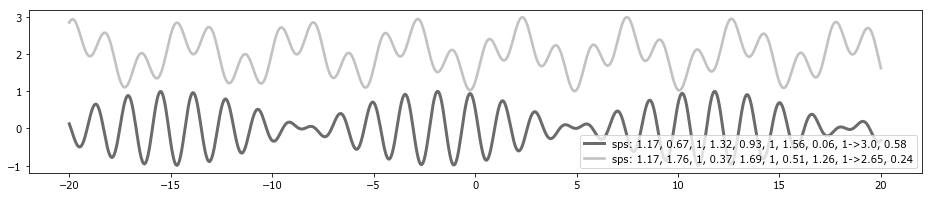

In [48]:
# Random search paras:
figure(figsize=(16,3))
DrawCu("sps",yo=0); DrawCu("sps",yo=2);
legend(loc='lower right'); show()

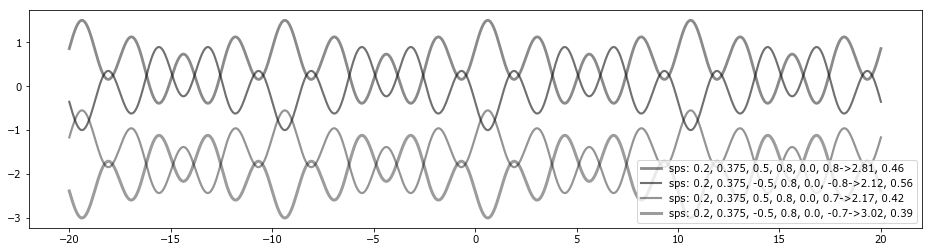

In [49]:
# Finetune paras of sps:
figure(figsize=(16,4))
#p = [0.1, 0.5, 5, 1, 0.0, 2]; DrawCu("sps", p, yo=2)
#p = [0.05, 0.5, 1, 0.8, 0.0, 2]; DrawCu("sps", p, yo=0)
#p = [0.1, 0.5, 1, 1.0, 0.0, 0.5]; DrawCu("sps", p, yo=2)
#p = [0.1, 0.0, 1, 0.5, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.1, 0.0, 1, 0.7, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.1, 0.0, 1, 0.7, 0.0, 0.4]; DrawCu("sps", p, yo=0)

#p = [1.1, 0.0, 1, 0.8, 0.05, 1]; DrawCu("sps", p, yo=2)
#p = [0.6, 0.5, 1, 0.75, 1.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.25, 0.7, 1, 0.5, 0.9, 1]; DrawCu("sps", p, yo=2)
#p = [0.25, 0.25, 1, 1.0, -0.5, 1]; DrawCu("sps", p, yo=0)
#p = [0.25, 0.25, 1, 1.0, 0.5, 1]; DrawCu("sps", p, yo=2)
#p = [0.5, 0.0, 1, 0.3, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [0.5, 0.0, 1, 0.7, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.6, 0.0, 1, 1.0, 0.0, 1]; DrawCu("sps", p, yo=0)
#p = [1.0, 0.0, 1, 1.2, 0.5, 1]; DrawCu("sps", p, yo=2)
#p = [0.8, 0.0, 1, 1.0, 0.63, 1]; DrawCu("sps", p, yo=0)
#p = [0.8, 0.0, 1, 1.2, 0.75, 1]; DrawCu("sps", p, yo=2)
#p = [1.5, 0.5, 1, 1.8, 1.5, 1]; DrawCu("sps", p, yo=0)

#p = [0.8, 1.5, 0.5, 1.0, 0.5, 1.5]; DrawCu("sps", p, yo=2)
#p = [0.8, 0.5, 0.4, 0.3, 0.0, 0.4]; DrawCu("sps", p, yo=0)

#p = [0.1, 3/8, 1, 0.4, 0.0, 1]; DrawCu("sps", p, yo=2)
#p = [0.2, 3/8, 1, 0.8, 0.0, 1]; DrawCu("sps", p, yo=0) # Good
#p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.8]; DrawCu("sps", p, yo=0) # Good
p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.8]; DrawCu("sps", p, yo=0.5) # Good
p = [0.2, 3/8, -0.5, 0.8, 0.0, -0.8]; DrawCu("sps", p, yo=0) # Good
p = [0.2, 3/8, 0.5, 0.8, 0.0, 0.7]; DrawCu("sps", p, yo=-1.55) # Good
p = [0.2, 3/8, -0.5, 0.8, 0.0, -0.7]; DrawCu("sps", p, yo=-2) # Good
legend(loc='lower right'); show()

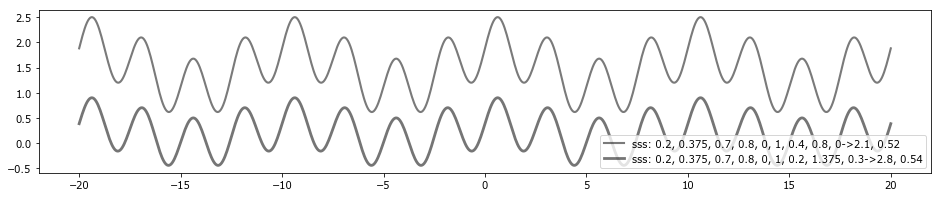

In [50]:
# Finetune paras of sss:
figure(figsize=(16,3))
#p = [1.0, 0.0, 1, 1.2, 0.5, 1, 0.05, 0.0, 0.2]; DrawCu("sss", p, yo=2)
#p = [1.0, 0.0, 1, 1.2, 0.5, 1, 0.05, 0.35, 1]; DrawCu("sss", p, yo=0)
#p = [1.0, 0.0, 1, 1.2, 1.5, 0.3, 0.02, 0.35, 0.6]; DrawCu("sss", p, yo=2)
p = [0.2, 3/8, 0.7, 0.8, 0, 1, 0.4, 0.8, 0]; DrawCu("sss", p, yo=1.5)
p = [0.2, 3/8, 0.7, 0.8, 0, 1, 0.2, 11/8, 0.3]; DrawCu("sss", p, yo=0.2)
#p = [0.2, 3/8, -0.7, 0.8, 0, -1, 0.2, 11/8, -0.3]; DrawCu("sss", p, yo=0)
legend(loc='lower right'); show()

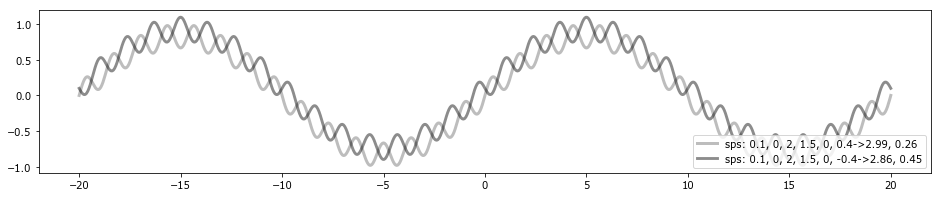

In [51]:
# Search paras for Type2:
figure(figsize=(16,3))
p = [0.1, 0, 2, 1.5, 0, 0.4]; DrawCu("sps", p, yo=0)
p = [0.1, 0, 2, 1.5, 0, -0.4]; DrawCu("sps", p, yo=0.1)
legend(loc='lower right'); show()

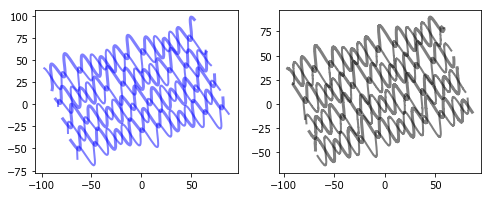

In [58]:
# Test Rotations:
figure(figsize=(8,3)); tp = (0,1,0.1); wa = [3,0.4, 2,0.5]
subplot(1,2,1);
for i in range(4): DrawCel(tp, 80, (i-1)*1.5, 0.1, wa, f=8)
subplot(1,2,2);
for i in range(4): DrawCell(tp, 80, (i-1)*1.5, 0.1, wa, f=8)
show()

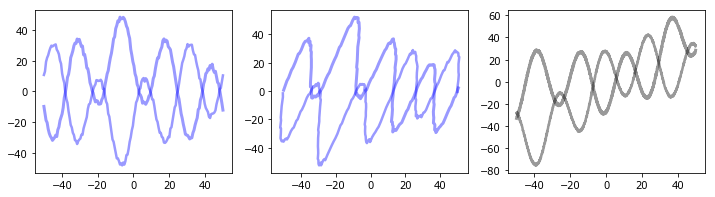

In [56]:
# Test Affine:
figure(figsize=(12,3)); tp = (4,0,0.2); wa = [3,0.4, 2.5,0.4]
ro = np.array([[1,0],[0,1]]);
af1 = np.array([[1,0.2],[0,1]]);
af2 = np.array([[1,0],[0.6,1]]);
subplot(1,3,1); DrawCel(tp, 50, 0, ro, wa, f=5);
subplot(1,3,2); DrawCel(tp, 50, 0, af1, wa, f=5);
subplot(1,3,3); DrawCell(tp, 50, 0, af2, wa, f=5);
show()

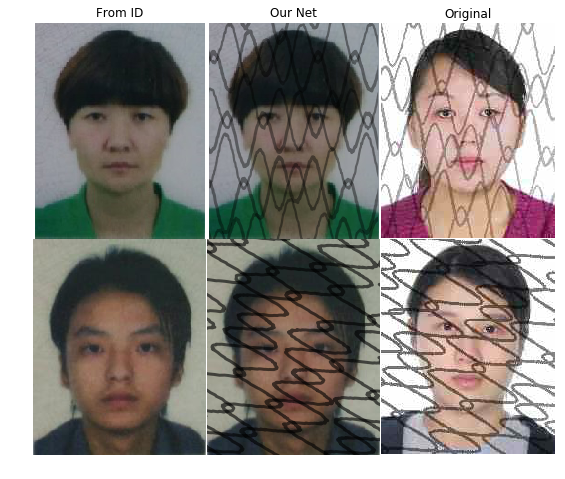

In [96]:
# Test Type0:
figure(figsize=(7.25,6))

im = imread("./Test/111.jpg");
im2 = imread("./Test/N1.1.jpg");
tp = (0, 1, 0.4); wa = [2.2,0.4, 3,0.4];
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp, ro=0.0, wa=wa); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

im = imread("./Test/222.jpg");
im2 = imread("./Test/N1.2.jpg");
tp = (0, 1, 0.4); wa = [3,0.6, 3,0.6];
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp, ro=0.4, wa=wa);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out1.jpg"); show()

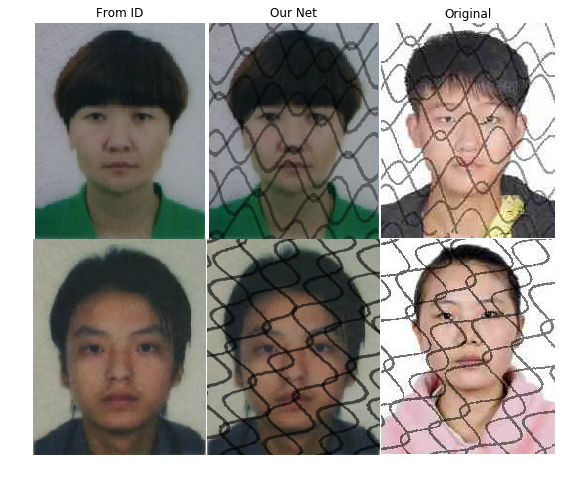

In [97]:
# Test Type1:
figure(figsize=(7.25,6))

im = imread("./Test/111.jpg");
im2 = imread("./Test/N2.1.jpg");
tp = (1, 1, 0.45); wa = [2.5,0.5, 3,0.4];
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp, ro=-0.03, wa=wa, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

im = imread("./Test/222.jpg");
im2 = imread("./Test/N2.4.jpg");
tp = (1, 1, 0.45); a = [2.2,0.7, 2.8,0.6];
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp, ro=0.42, wa=wa, gap=1.6);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out2.jpg"); show()

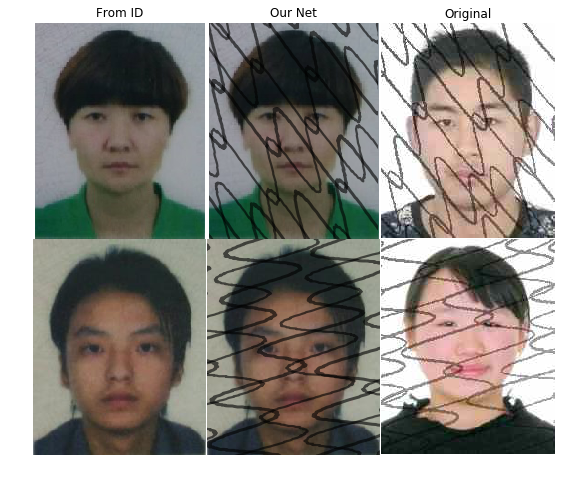

In [99]:
# Test Type2:
figure(figsize=(7.25,6));

im = imread("./Test/111.jpg");
im2 = imread("./Test/N3.6.jpg");
tp = (2, 1, 0.3); wa = [3,0.6, 2.2,0.6];
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp, ro=0, wa=wa, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

im = imread("./Test/222.jpg");
im2 = imread("./Test/N3.1.jpg");
tp = (2, 1, 0.3); wa = [3,0.6, 2.2,0.6];
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp, ro=0.39, wa=wa, gap=1.55);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out3.jpg"); show()

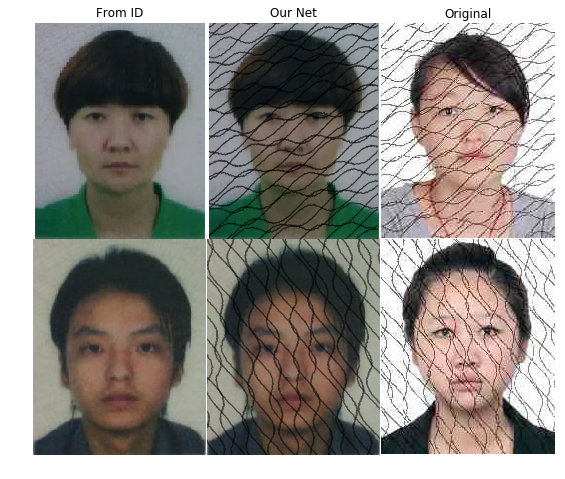

In [5]:
# Test Type3:
figure(figsize=(7.25,6)); tp = (3, 1, 0.6);

im = imread("./Test/111.jpg");
im2 = imread("./Test/N4.2.jpg");
subplot(2,3,1); imshow(im); axis("off"); title("From ID");
subplot(2,3,2); Add2Im(im, tp, ro=0.25, gap=1.6); title("Our Net");
subplot(2,3,3); imshow(im2); axis("off"); title("Original");

im = imread("./Test/222.jpg");
im2 = imread("./Test/N4.4.jpg");
subplot(2,3,4); imshow(im); axis("off");
subplot(2,3,5); Add2Im(im, tp, ro=-0.26, gap=1.7);
subplot(2,3,6); imshow(im2); axis("off");

savefig("./Test/out4.jpg"); show()

In [5]:
# Test SaveIm:
src = "E:/Hua/PyCharm/Test"
tp = [range(4), 0, 0.3]
tp = [range(4), 1, 0.3]
BatchSave(src, tp, qt=95, num=3, ms=None);
print(os.getcwd())

E:\FacePic


In [6]:
#!/usr/bin/python3
import os
def SelDir(src, beg, end):
    for pp,sub,ff in os.walk(src): break
    #sub = list(os.walk(org))[0][1]; # too slow
    sub = [i for i in sub if beg<=int(i)<=end]
    os.chdir(src); ff = "../List.txt";
    with open(ff,"w") as f: # save sub
        for i in sub: f.write(i+"\n")
    return sub

src = "E:/FacePic/WebFace";
SelDir(src, 0, 99) # 0-263, 268-473

['0000045', '0000099']

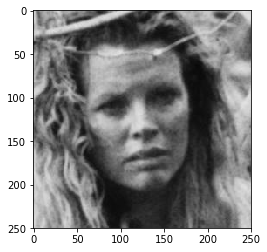

d h
w u
s a
Inequation: True


In [3]:
import os,cv2
from pylab import *
# Transform cv2.image <-> pylab.image
im = cv2.imread("E:/FacePic/WebFace/0000107/010.jpg")
im = im[:,:,::-1] # cv2.image <-> pylab.image
#im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imshow(im); show()

im = im[:,:,::-1] # pylab.image <-> cv2.image
#im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
cv2.imshow("Test",im); cv2.waitKey(2000); cv2.destroyAllWindows()

for i,j in zip("dwsa","hua"): print(i,j) # Test zip
print("Inequation:", 1<int("3")<5) # Test inequation

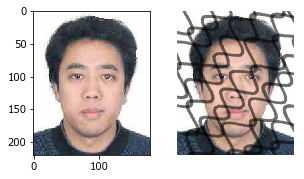

In [62]:
import os, cv2 #,matplotlib; matplotlib.use('Agg')
import matplotlib.pyplot as plt # import matplotlib & numpy

img=plt.imread('meshtest.jpg')
plt.subplot(2,3,1); plt.imshow(img)
tp = (1, 0, 0.3); #wa = [2.2,0.7, 2.8,0.6];
plt.subplot(2,3,2); Add2Im(img, tp, ro=1.3);
# plt.subplot(2,3,3); Add2Im(img, tp, ro=-0.26, gap=1.7);
# plt.subplot(2,3,4); Add2Im(img, tp, ro=0.39, gap=1.55);
# plt.subplot(2,3,5); Add2Im(img, tp, ro=0.25, gap=1.6);
# plt.subplot(2,3,6); Add2Im(img, tp, ro=0.0);

plt.show()